### Import dependencies

In [4]:
# import dependencies
import os
import seaborn as sns
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Set globa varables

In [5]:
START = datetime(2016, 1, 1)
END = datetime(2021, 2, 16)
BUCKET = 1  # day

### Load Data

In [6]:
# Load data
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [7]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [8]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [10]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,0.0
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,0.0
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,0.0
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,0.0
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,0.0
...,...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,0.0
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,0.0
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200,0.0


### EDA

#### Check for missing values

In [49]:
# Check missing values
# Use interpolate
# Drop bonds as they add no data
all_data[all_data.isna().any(axis=1)]

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/18/2016,1245.635545,NaN,NaN,NaN,NaN,NaN,1.0892,NaN,NaN
2/15/2016,1070.457234,NaN,NaN,NaN,NaN,NaN,1.1180,NaN,NaN
3/25/2016,2.655447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/28/2016,28.294602,15.24,2037.050049,2.809090e+09,1219.900024,33.0,NaN,1.87,0.0
5/30/2016,484.661910,NaN,NaN,NaN,NaN,NaN,1.1139,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11/26/2020,3013.808951,NaN,NaN,NaN,NaN,NaN,1.1900,NaN,NaN
11/27/2020,3520.232596,20.84,3638.350098,2.778450e+09,NaN,NaN,1.1922,NaN,NaN
12/24/2020,936.569447,21.53,3703.060059,1.885090e+09,NaN,NaN,1.2193,NaN,NaN


<Axes: xlabel='date'>

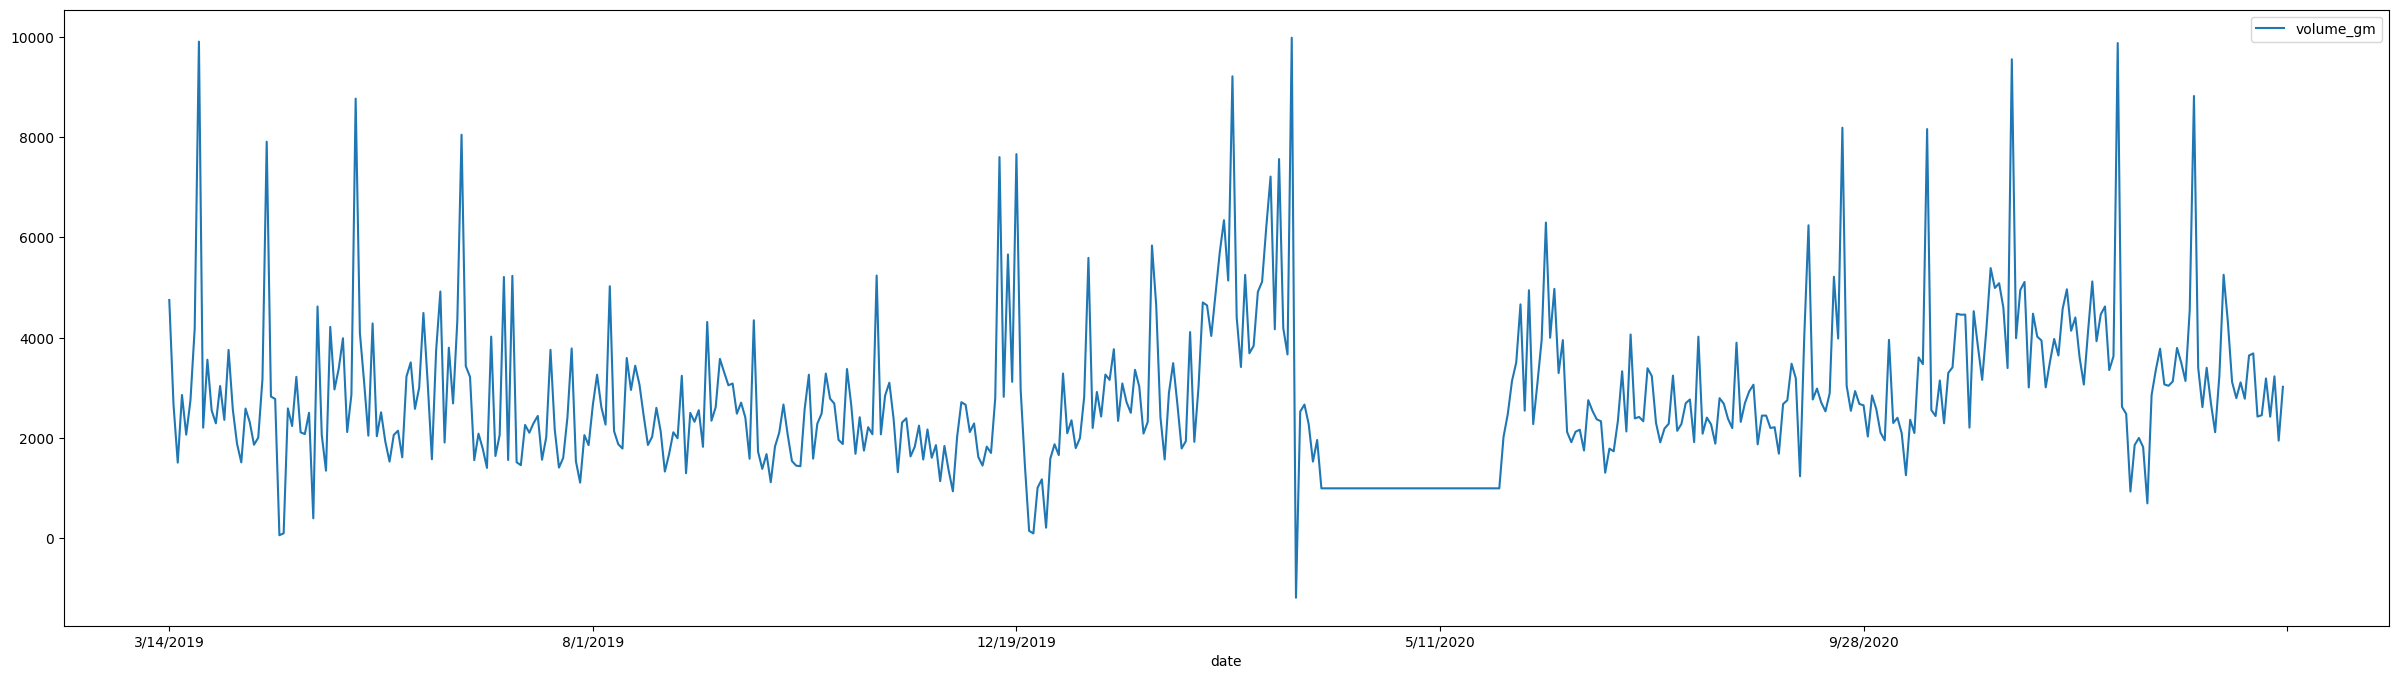

In [62]:
# No trend
# Yes seasonality around 30 days
all_data.iloc[-500:].plot(y='volume_gm', figsize=[30, 8])

<Axes: xlabel='date'>

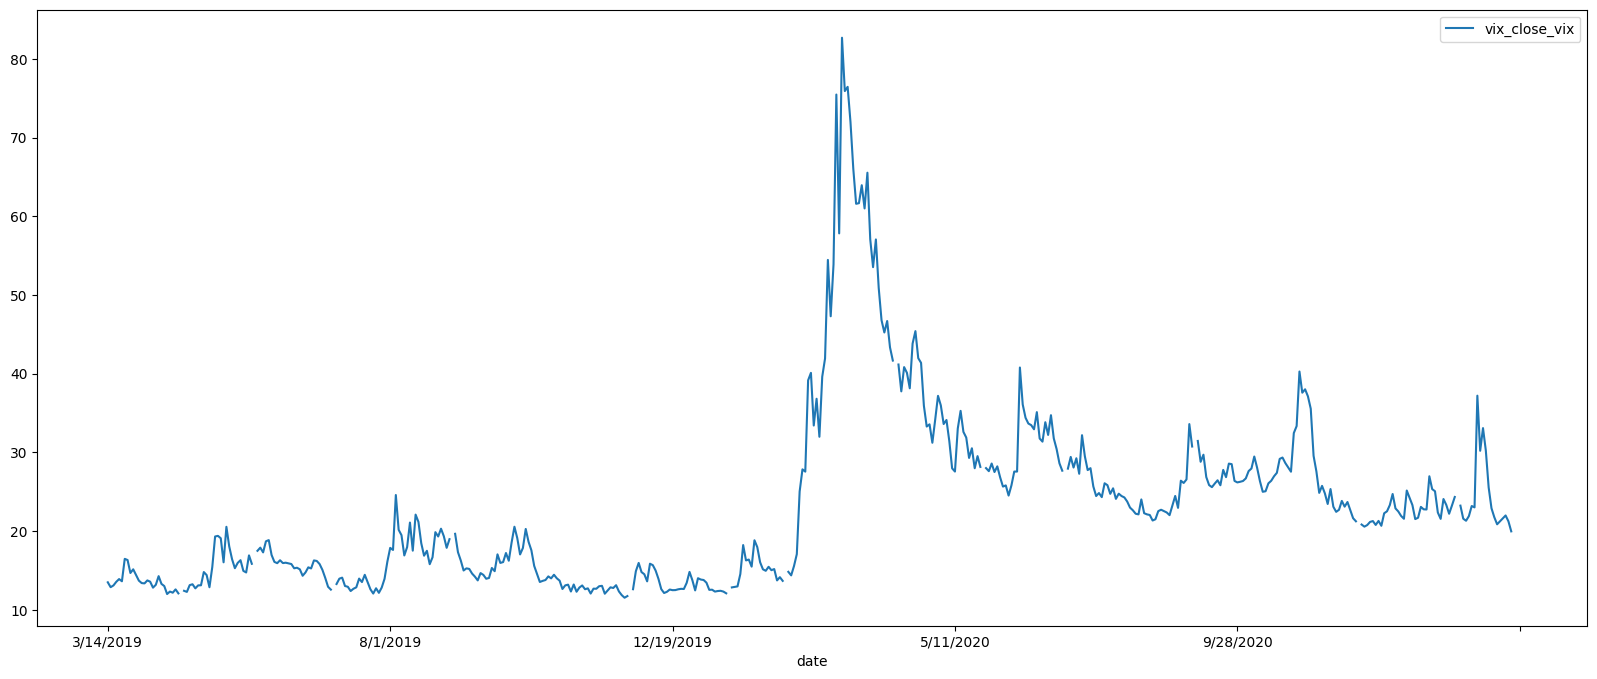

In [12]:
all_data.iloc[-500:].plot(y='vix_close_vix', figsize=[20, 8])

<Axes: xlabel='date'>

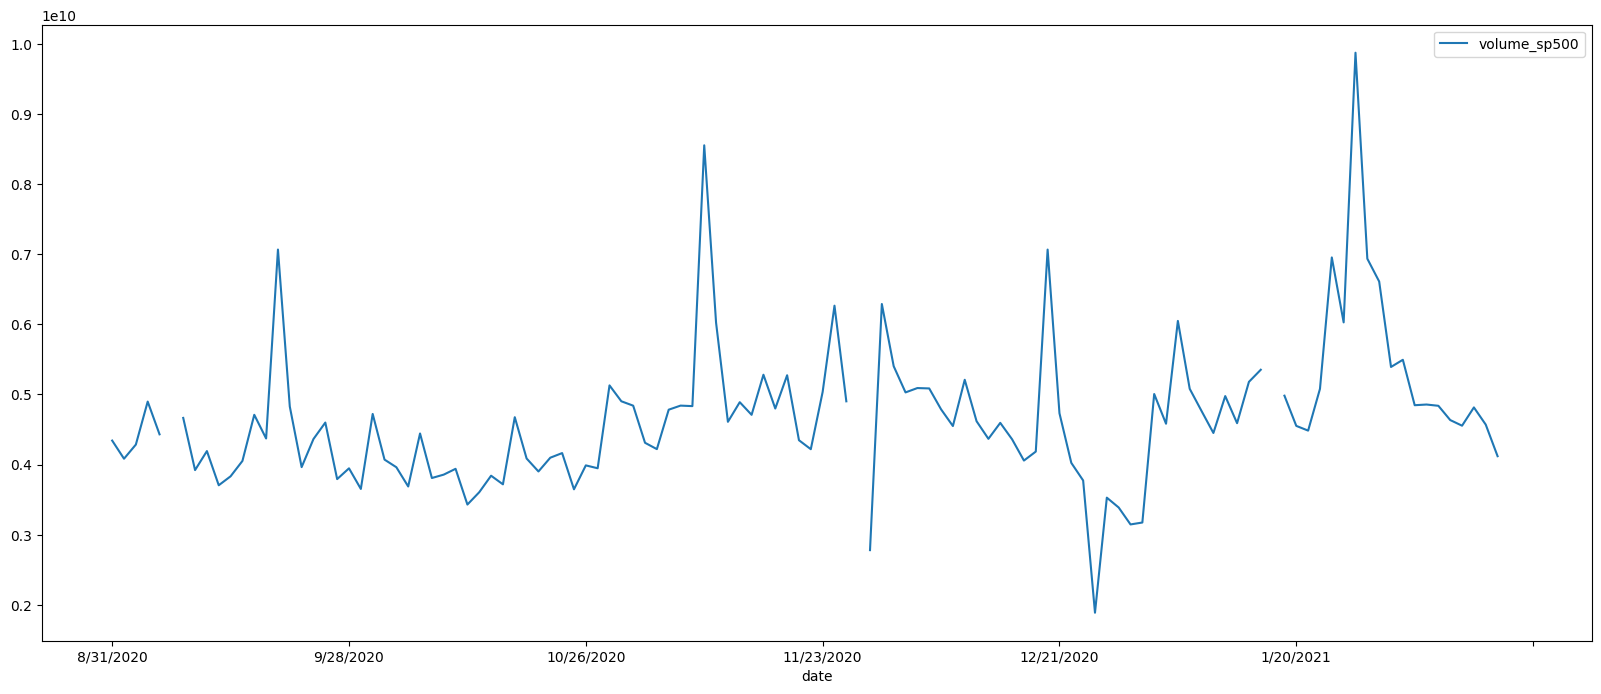

In [50]:
all_data.iloc[-120:].plot(y='volume_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

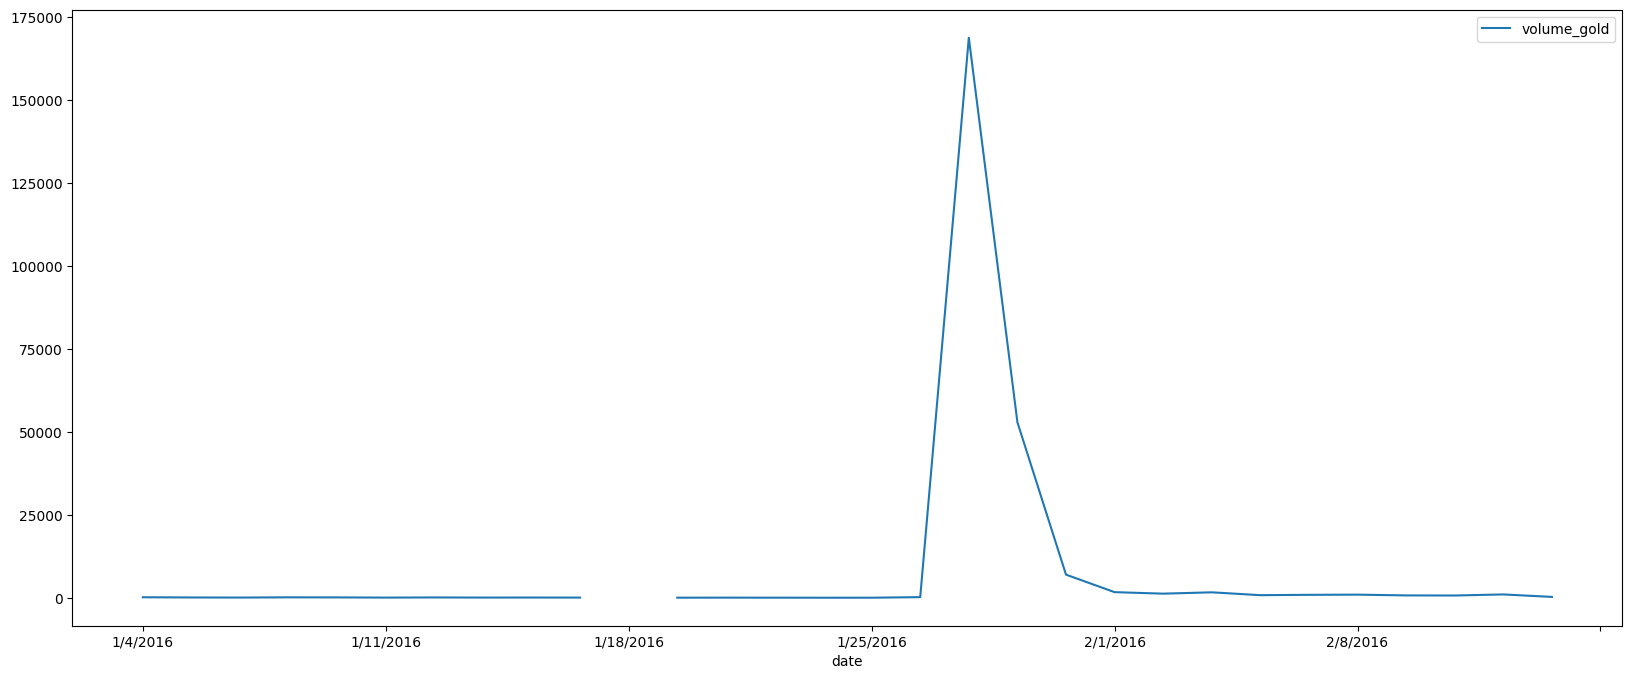

In [70]:
all_data.iloc[:30].plot(y='volume_gold', figsize=[20, 8])

<Axes: xlabel='date'>

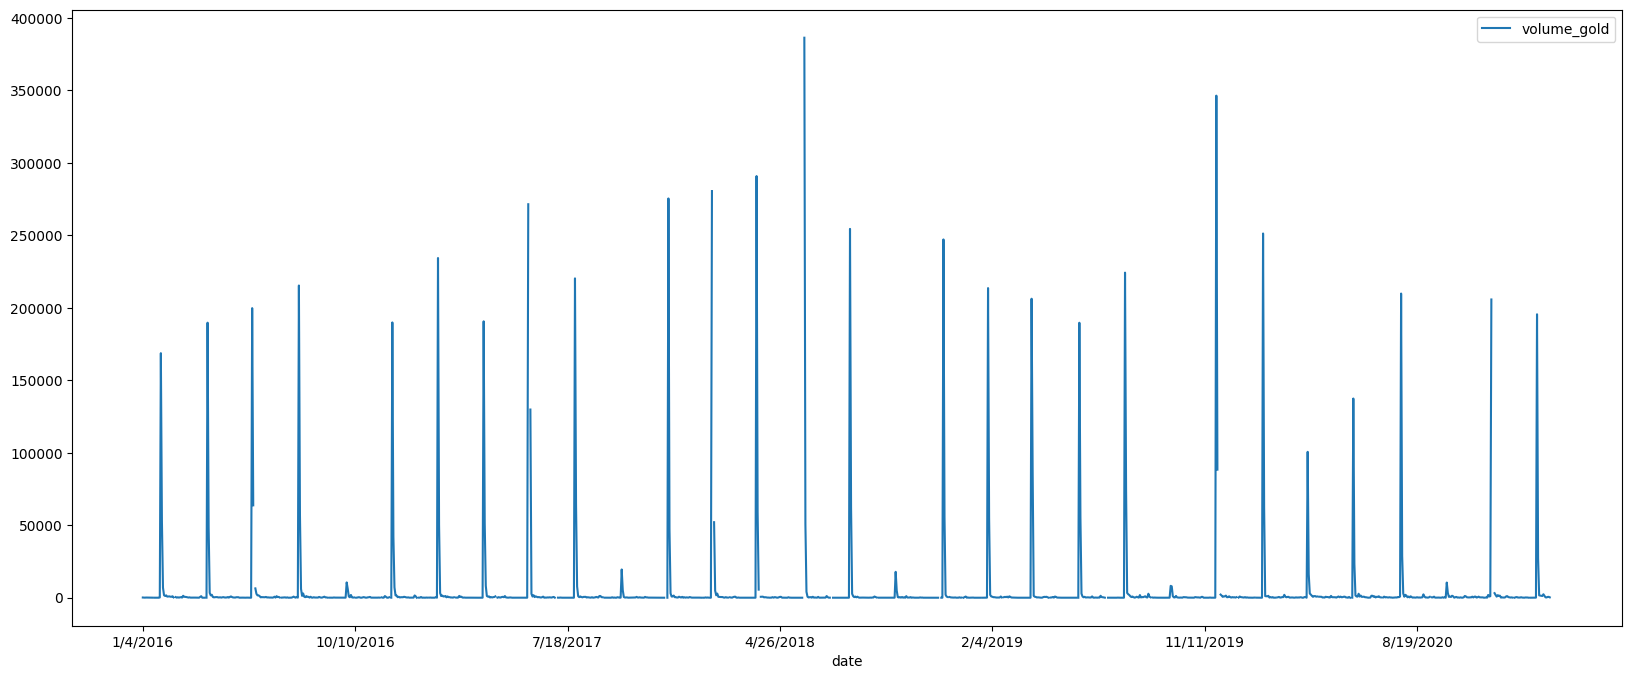

In [15]:
# Clear seasonality
all_data.plot(y='volume_gold', figsize=[20, 8])

<Axes: xlabel='date'>

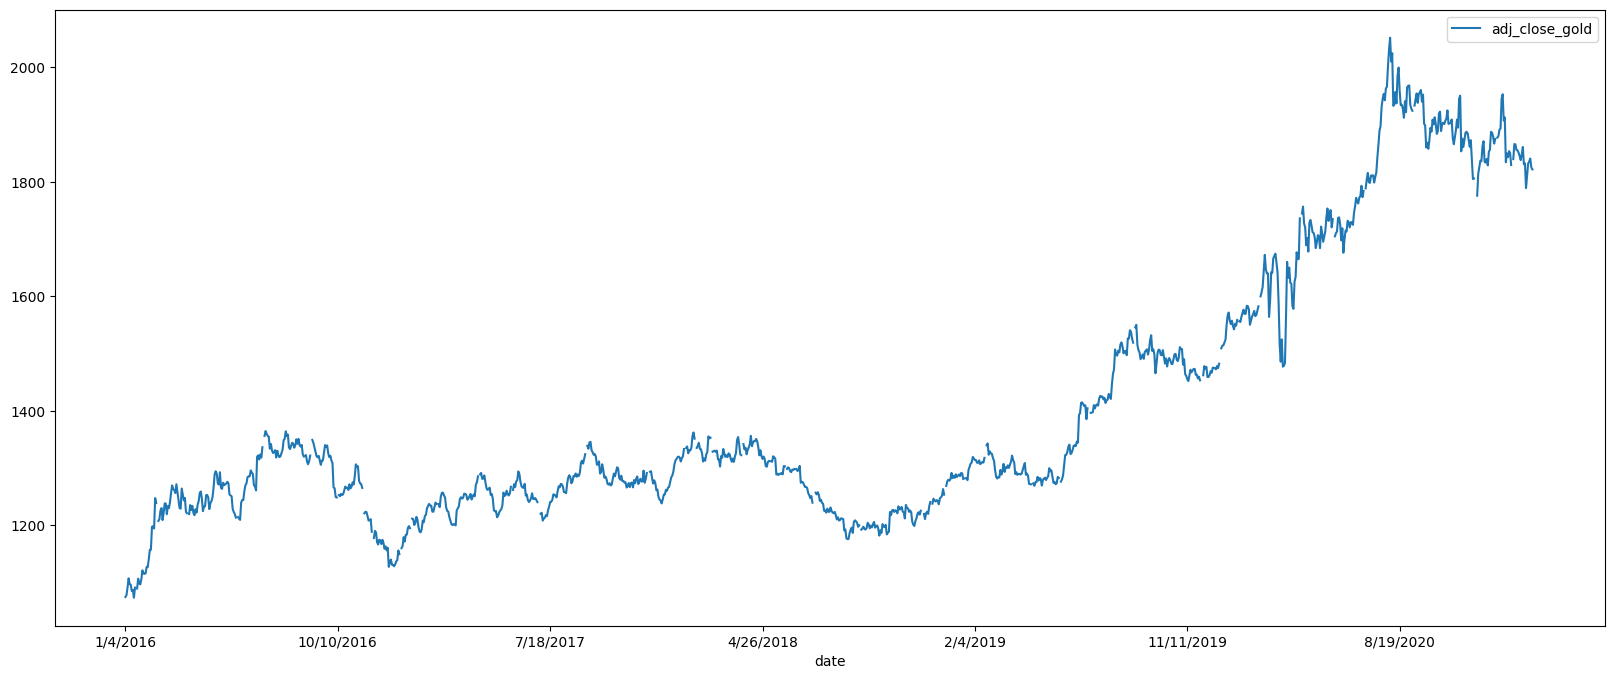

In [16]:
# Ascending trend
all_data.plot(y='adj_close_gold', figsize=[20, 8])

<Axes: xlabel='date'>

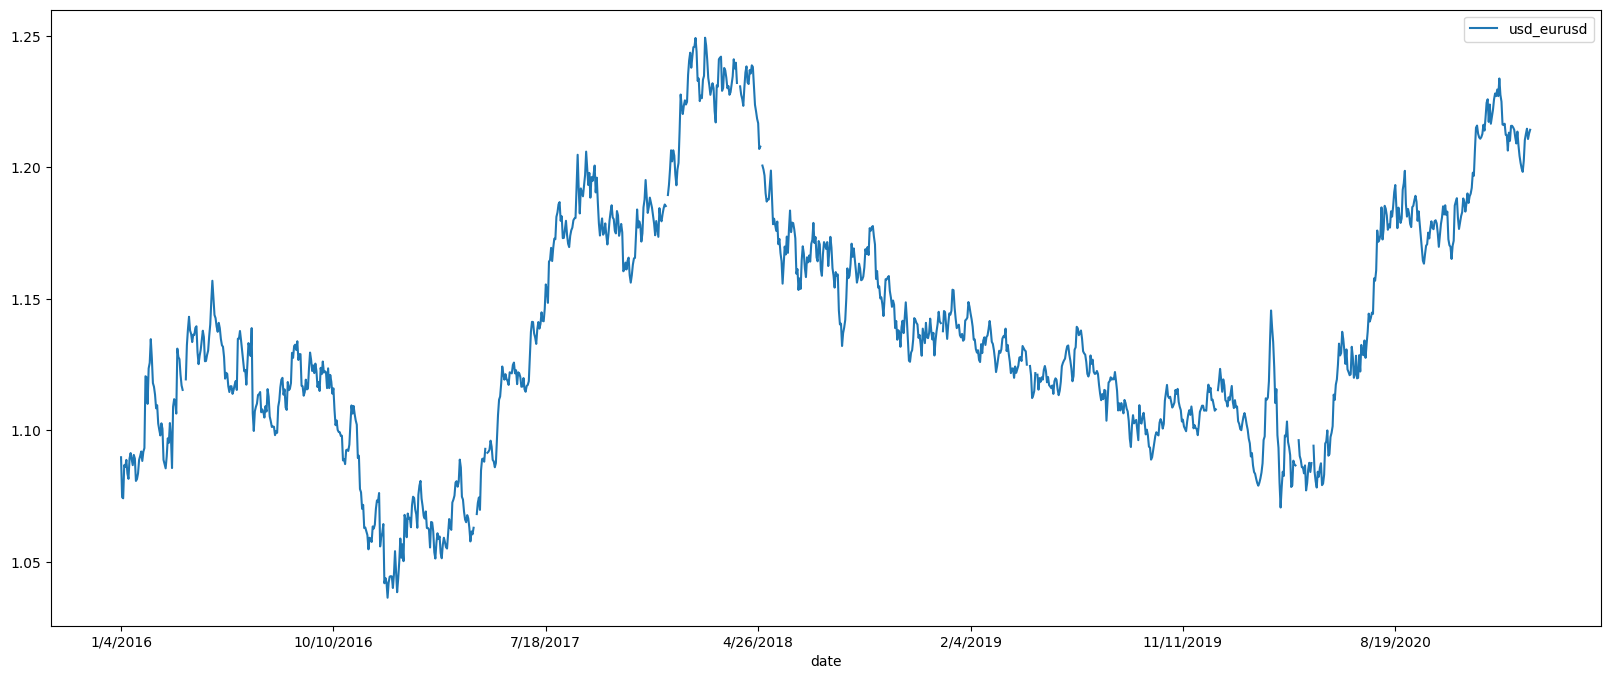

In [17]:
all_data.plot(y='usd_eurusd', figsize=[20, 8])

<Axes: xlabel='date'>

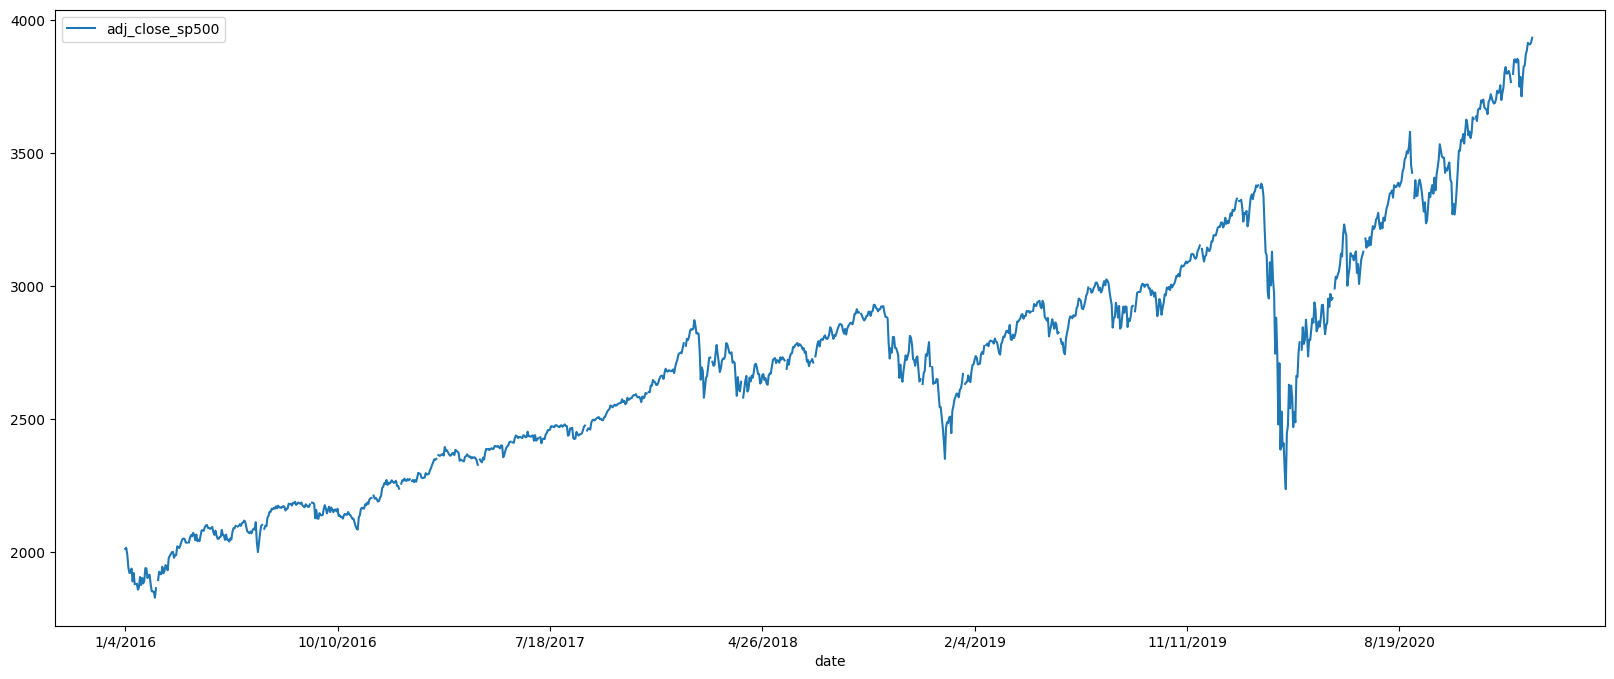

In [18]:
# Ascending trend
all_data.plot(y='adj_close_sp500', figsize=[20, 8])

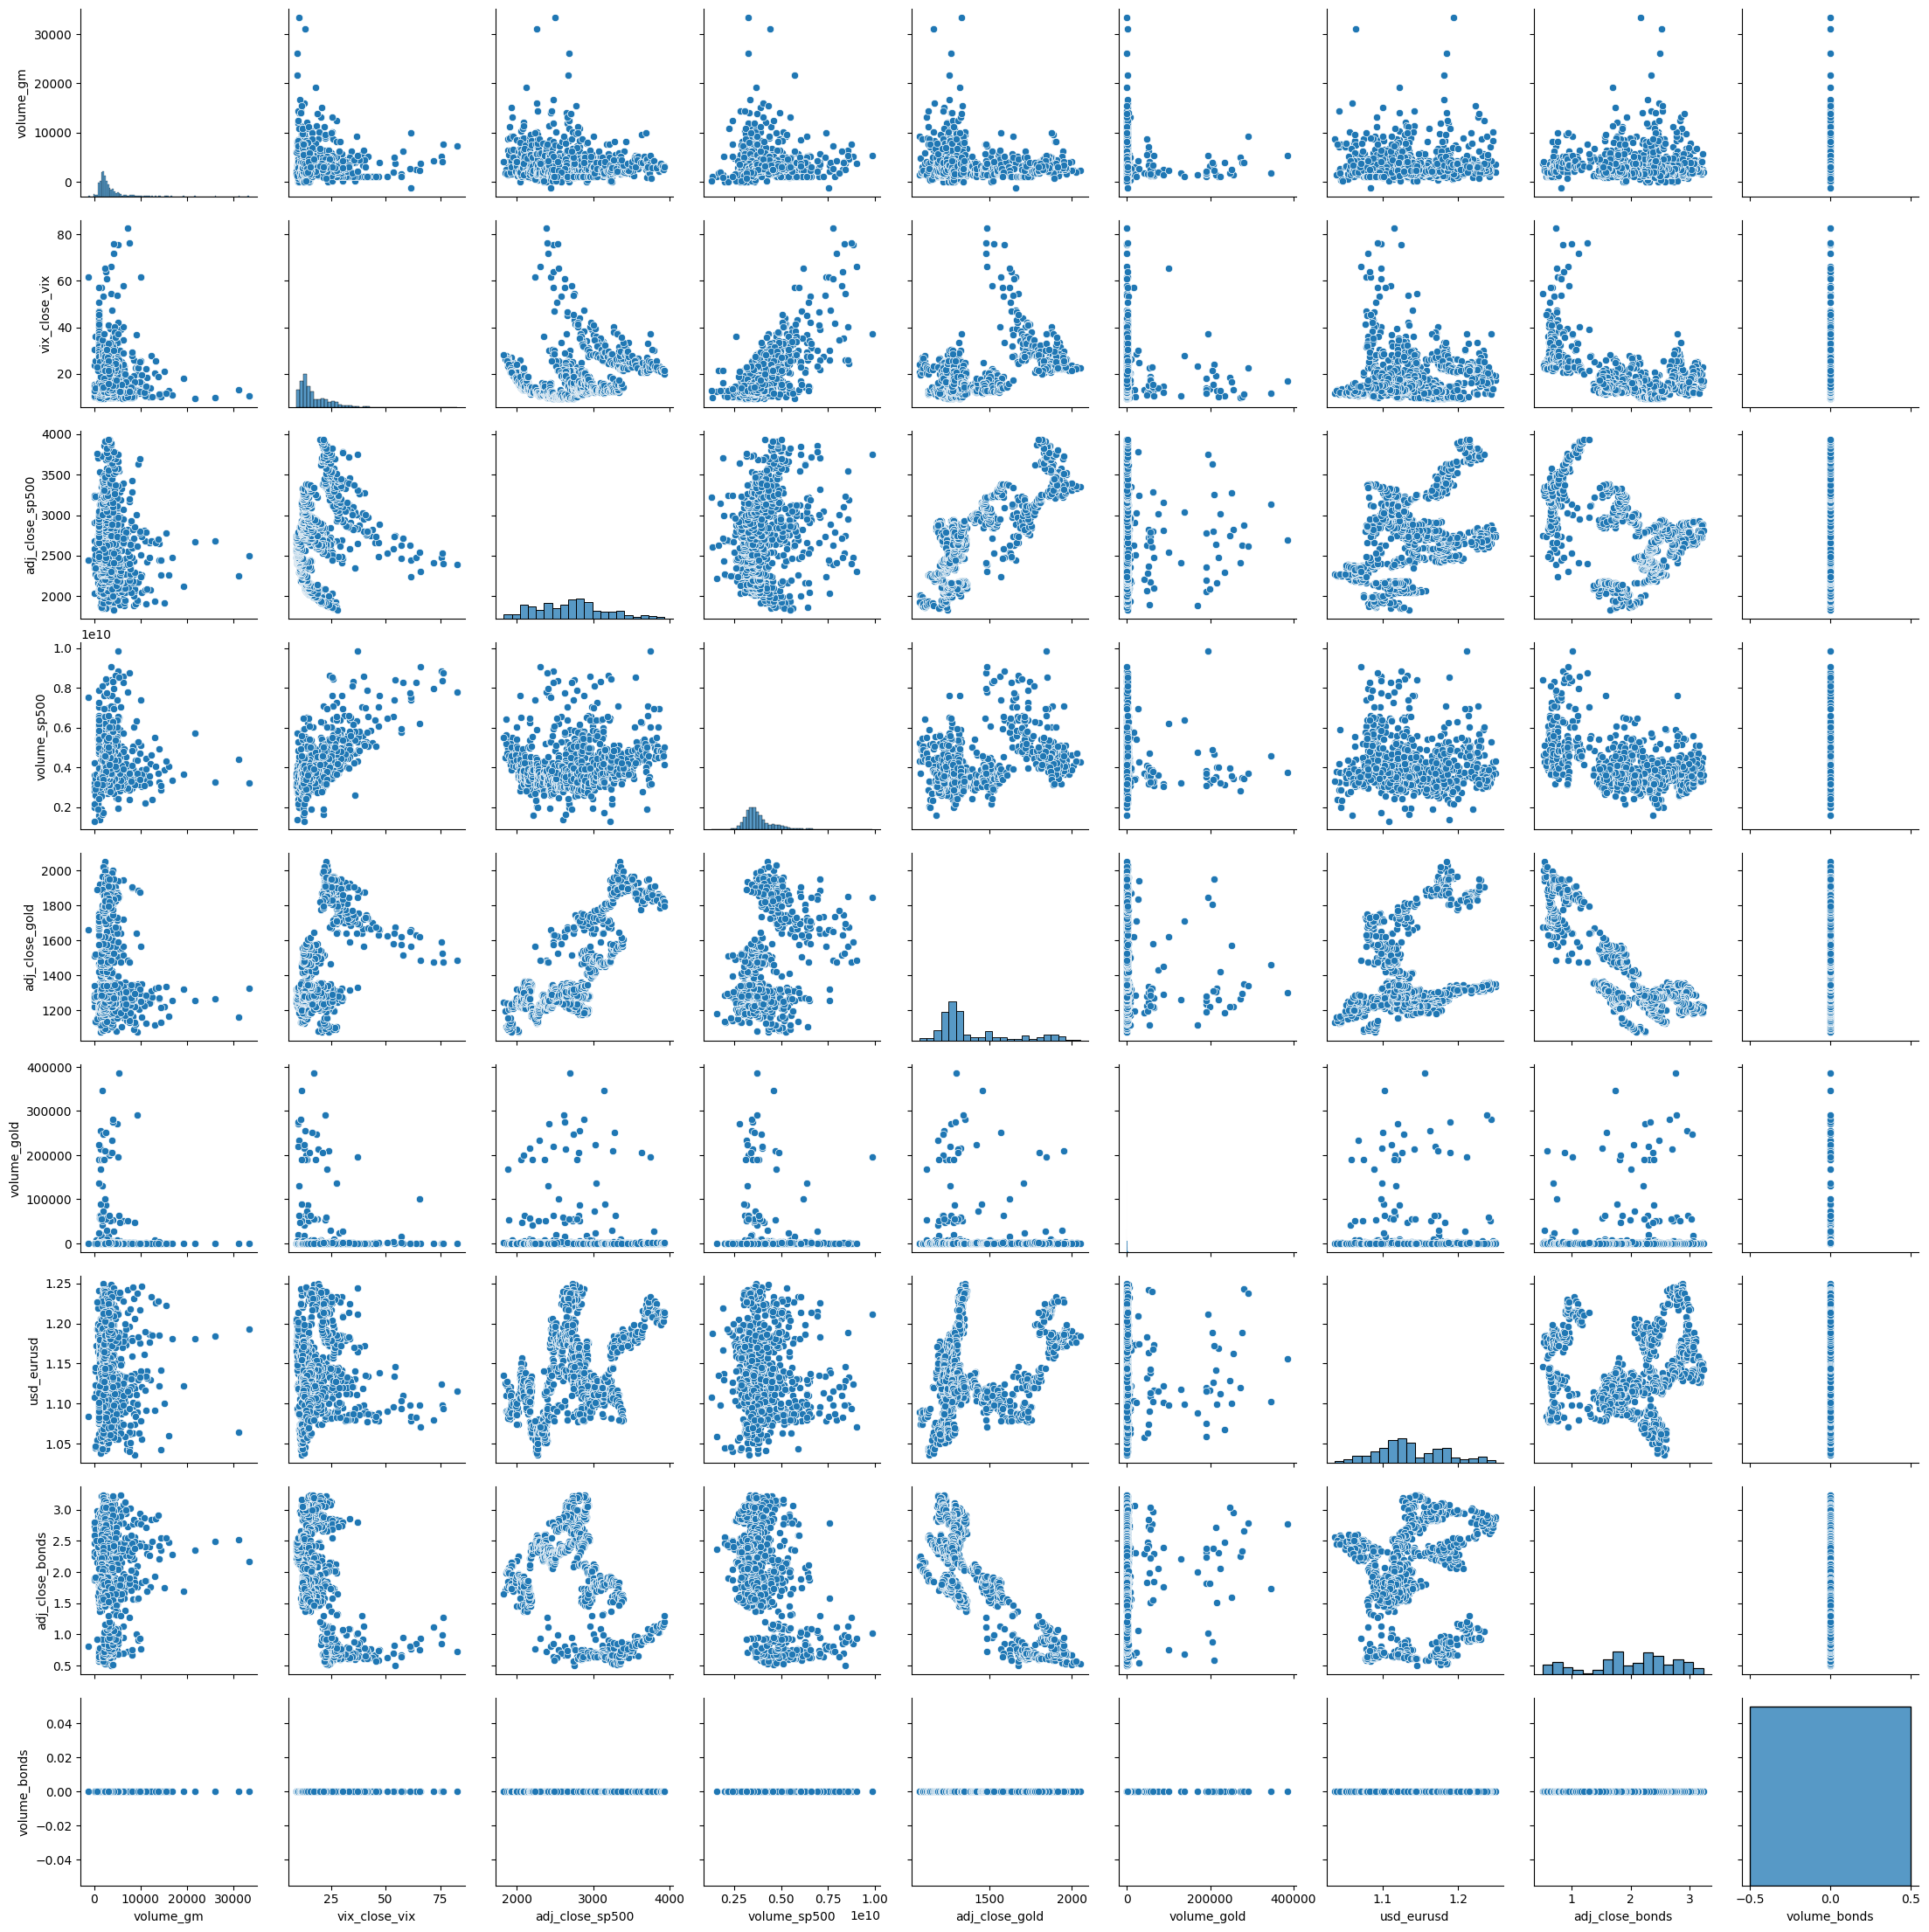

In [19]:
sns.pairplot(all_data)

#### Plot autocorrelation 

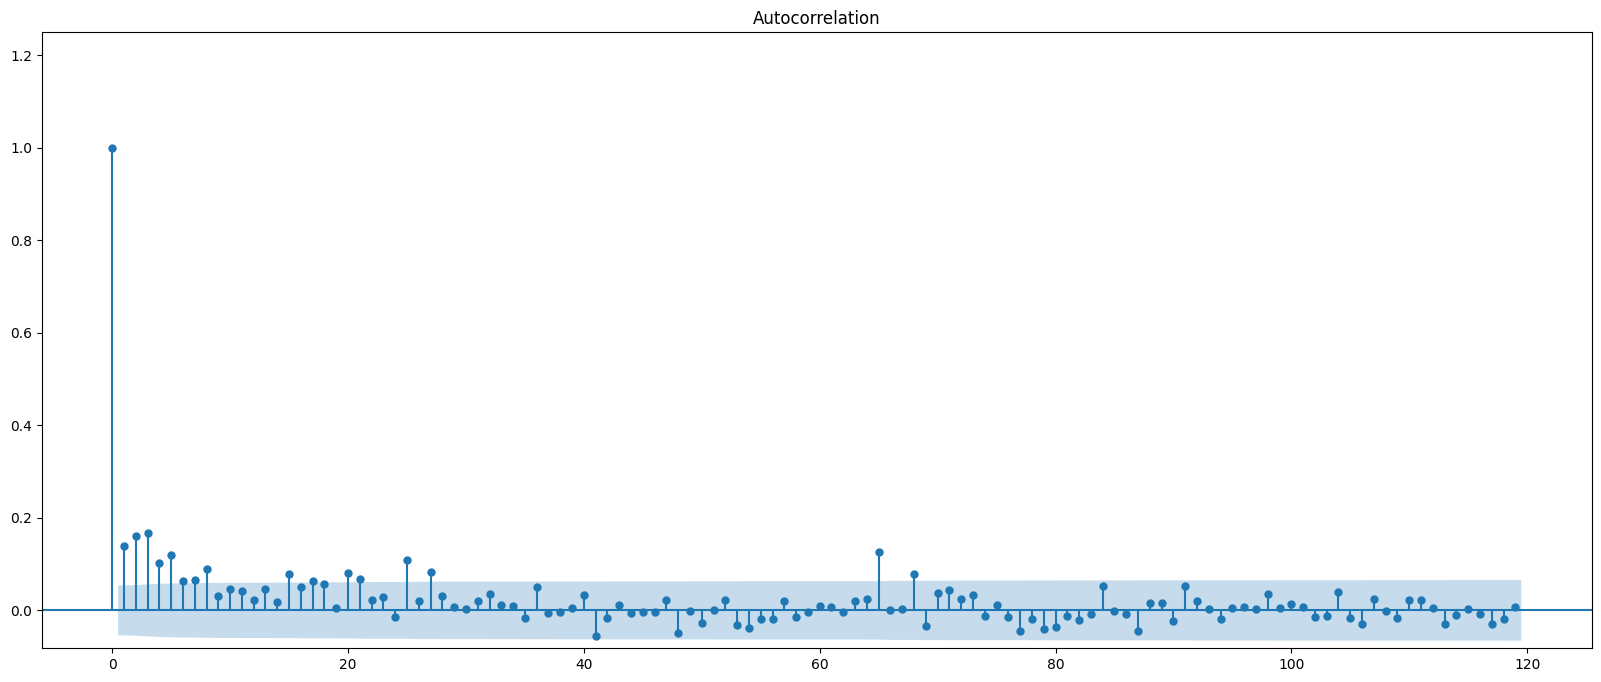

In [54]:
# VOLUME_GM
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data['volume_gm'], 
                    ax = ax, 
                    lags = np.arange(120), 
                    auto_ylims = True)

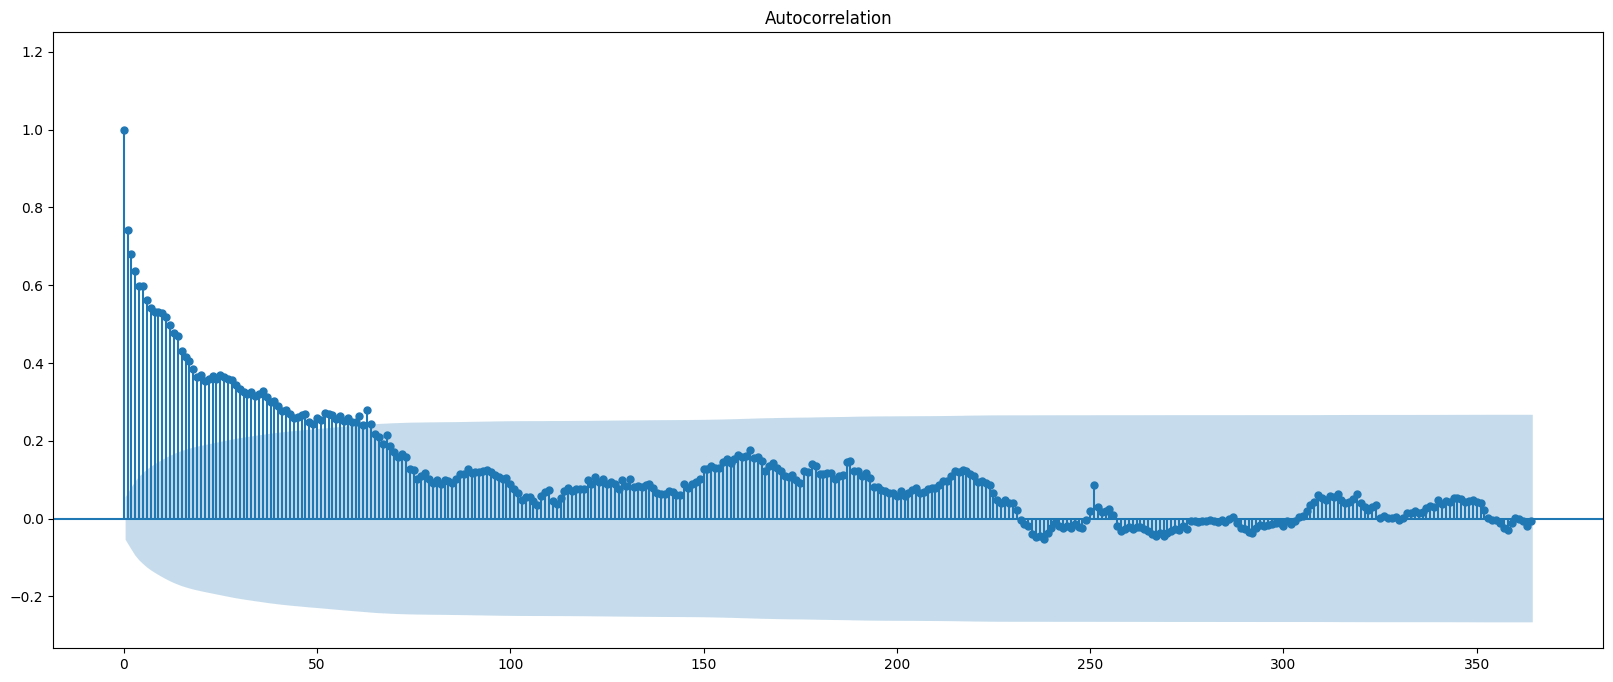

In [30]:
# VOLUME_SP500
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["volume_sp500"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

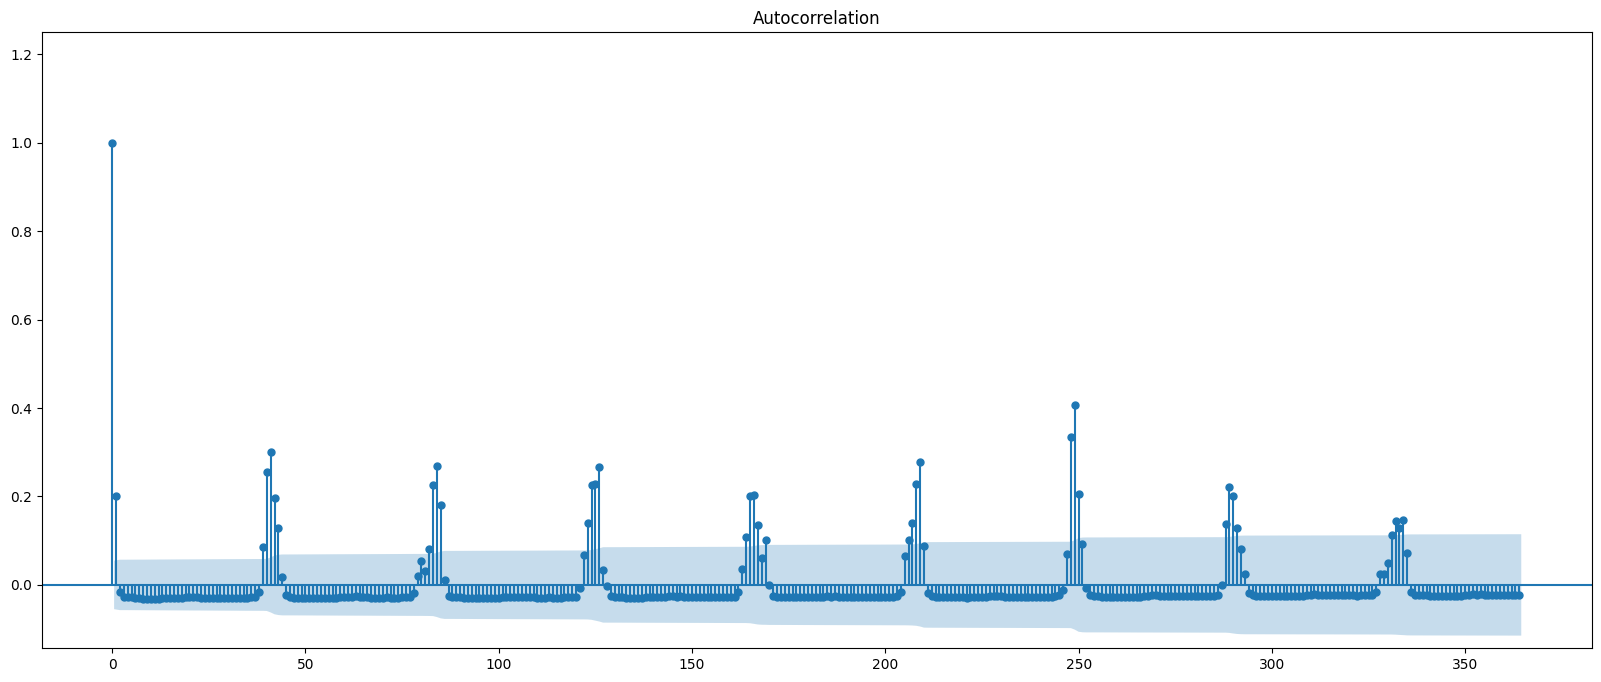

In [29]:
# VOLUME_GOLD
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["volume_gold"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

#### Plot parcial correlation

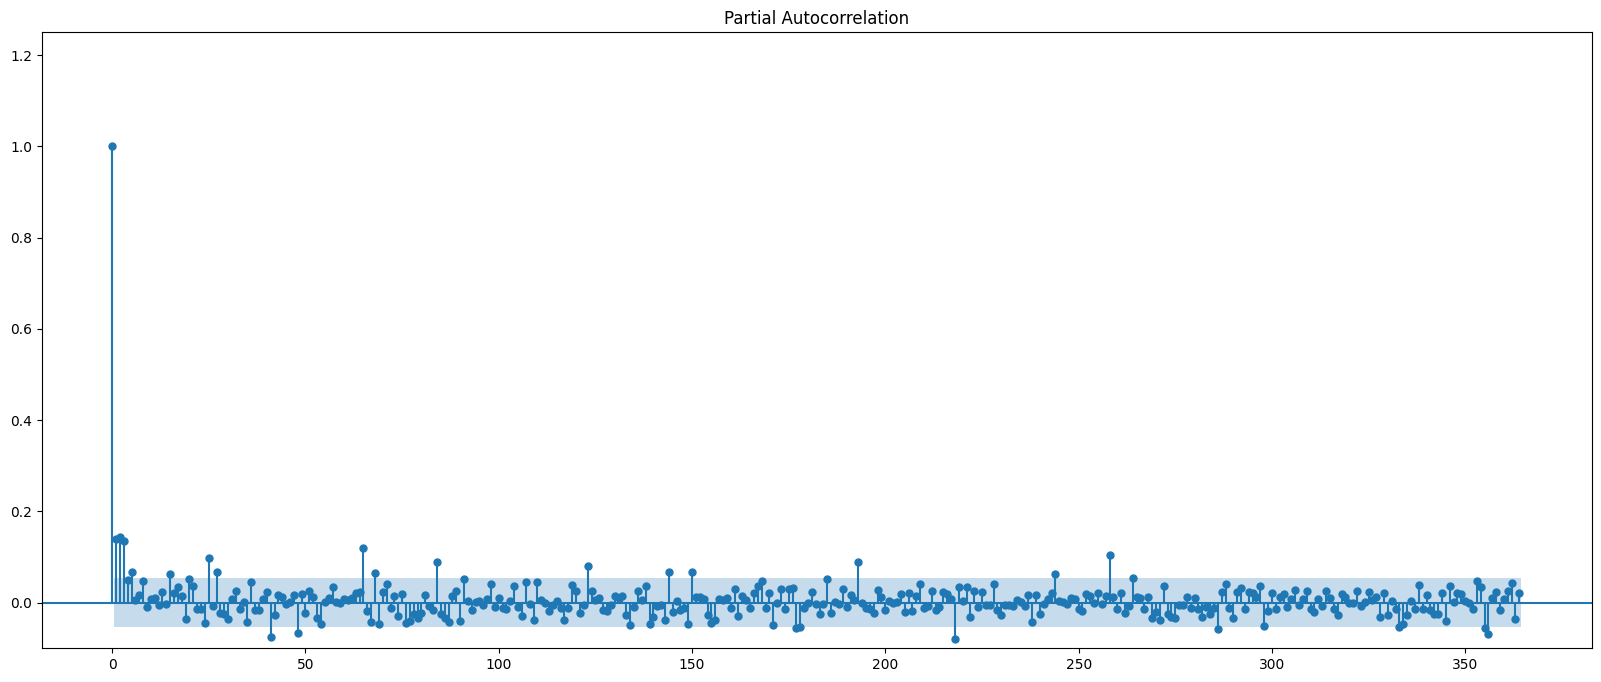

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(all_data['volume_gm'], 
                     ax = ax, 
                     lags = np.arange(365), 
                     auto_ylims = True, 
                     method='ywm')